In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove6b100dtxt/glove.6B.100d.txt
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


# Import the files

In [2]:
import keras
from nltk.stem.porter import PorterStemmer
import re
import string
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle
from tqdm import tqdm
import tensorflow as tf

2025-07-13 06:20:11.487563: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752387611.735977      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752387611.816309      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_data = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_data = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [4]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
print(train_data.head())
print("length od data is: ", len(train_data))

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
length od data is:  7613


Lets drop the keyword and location columns

In [6]:
train_data.drop(columns = ["keyword", "location"], inplace = True)
print(train_data.head())

   id                                               text  target
0   1  Our Deeds are the Reason of this #earthquake M...       1
1   4             Forest fire near La Ronge Sask. Canada       1
2   5  All residents asked to 'shelter in place' are ...       1
3   6  13,000 people receive #wildfires evacuation or...       1
4   7  Just got sent this photo from Ruby #Alaska as ...       1


In [7]:
print("Unique text entries: ", train_data["text"].nunique())
print("Sum of text entries: ", len(train_data["text"]))

Unique text entries:  7503
Sum of text entries:  7613


In [8]:
# remove duplicate entries
train_data = train_data.drop_duplicates(subset = ["text"])
print("Sum of text entries: ", len(train_data["text"]))

Sum of text entries:  7503


Apply preprocessing to the textdata

#stemmer = PorterStemmer()

def preprocessing(textfile):
    return_file = list()
    
    for current_text in textfile:
        # convert all letters to lower case (seems to be initially the case but make sure it actually is)
        current_text = current_text.lower()
        
        # remove all numbers
        current_text = re.sub(r'\d+', '', current_text)
        
        # remove punctuation
        #translator = str.maketrans('', '', string.punctuation)
        #current_text.translate(translator)

        #remove special characters
        current_text = re.sub(r'[^a-zA-Z0-9]', ' ', current_text)

        # remove links
        current_text = re.sub('https?://\S+|www\.\S+', '', current_text)
        
        # remove line changes
        #current_text = re.sub('\n', '', current_text)
        
        # remove whitespace
        current_text = " ".join(current_text.split())
        
        # Apply Porter Stemmer
        #word_tokens = word_tokenize(current_text)
        #current_text = [stemmer.stem(word) for word in word_tokens]

        #current_text = " ".join(current_text)
        # current text is list item, change it to string, then return
        return_file.append("".join(current_text))
    
    df = pd.DataFrame({"Text": return_file})
    return df

train_data.text = preprocessing(train_data.text)
test_data.text = preprocessing(test_data.text)

In [9]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 7503 entries, 0 to 7612
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7503 non-null   int64 
 1   text    7503 non-null   object
 2   target  7503 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 234.5+ KB
None


In [10]:
train_data.dropna(inplace=True)
#test_data.dropna(inplace=True)

In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7503 entries, 0 to 7612
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7503 non-null   int64 
 1   text    7503 non-null   object
 2   target  7503 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 234.5+ KB


In [12]:
# Remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)



In [13]:
# Apply the emoji removal function
train_data.text=train_data.text.apply(lambda x: remove_emoji(x))
test_data.text=test_data.text.apply(lambda x: remove_emoji(x))

In [14]:
print(train_data.text[0])

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all


In [15]:
# Splitting the data into 2/3 as train and 1/3 as test
X_train, X_test, y_train, y_test = train_test_split(train_data['text'], train_data['target'], test_size=0.2)

In [16]:
print(y_train.shape)
print(X_train.shape)

(6002,)
(6002,)


In [17]:
vocab_size = 100000
trunc_type='post'
oov_tok = "<OOV>"

# Tokenization
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

In [18]:
print(X_train[0])
tokenizer.texts_to_sequences([X_train[0]])

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all


[[114, 5542, 26, 5, 857, 9, 22, 298, 141, 1792, 5578, 88, 41]]

Pad all sequences to have the same shape

In [19]:
word_index = tokenizer.word_index

In [20]:
max_length = 50

sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)

# Padding
train_padded = pad_sequences(sequences, maxlen=max_length, truncating="post", padding = "post")
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, truncating="post", padding = "post")

In [21]:
# Apply tokenizer on testdata
sequences_test_data = tokenizer.texts_to_sequences(test_data.text)
test_data_padded = pad_sequences(sequences_test_data, maxlen=max_length, truncating="post", padding = "post")

In [22]:
print(train_padded[0])
print(train_padded.shape)

[5932 5933  162    6  807 1475    5 1358   20   71   23 1155    6  116
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
(6002, 50)


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, GlobalMaxPool1D, Dense, Activation, Dropout, GRU, Embedding, Bidirectional, LSTM

model = Sequential()
model.add(Embedding(input_dim = vocab_size,output_dim = 64)) #, input_length = max_length
model.add(Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=0.2)))
model.add(Bidirectional(LSTM(32, return_sequences=True, recurrent_dropout=0.2)))
model.add(Bidirectional(LSTM(16, return_sequences=False, recurrent_dropout=0.2)))
#model.add(GlobalMaxPool1D())
#model.add(BatchNormalization())
#model.add(Dropout(0.3))
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))


I0000 00:00:1752387628.199530      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [24]:
import keras
opt = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
  optimizer=opt,
  loss='binary_crossentropy',
  metrics=['AUC'], # AUC ?
)

In [25]:
history = model.fit(
  train_padded,
  y_train,
  epochs=15,
  verbose = 1,
  shuffle = True,
    validation_data=(testing_padded, y_test))
   


Epoch 1/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 133s 566ms/step - AUC: 0.5263 - loss: 0.6841 - val_AUC: 0.6735 - val_loss: 0.6677
Epoch 2/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 103s 549ms/step - AUC: 0.6754 - loss: 0.6498 - val_AUC: 0.8166 - val_loss: 0.5482
Epoch 3/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 104s 554ms/step - AUC: 0.8603 - loss: 0.4634 - val_AUC: 0.8536 - val_loss: 0.4777
Epoch 4/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 103s 549ms/step - AUC: 0.9293 - loss: 0.3112 - val_AUC: 0.8592 - val_loss: 0.4880
Epoch 5/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 102s 541ms/step - AUC: 0.9600 - loss: 0.2271 - val_AUC: 0.8544 - val_loss: 0.5332
Epoch 6/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 103s 548ms/step - AUC: 0.9763 - loss: 0.1663 - val_AUC: 0.8503 - val_loss: 0.6291
Epoch 7/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 104s 554ms/step - AUC: 0.9805 - loss: 0.1440 - val_AUC: 0.8465 - val_loss: 0.6737
Epoch 8/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 102s 542ms/step - AUC: 0.9879 - loss: 0.1002 - val_AUC: 0.8438 - val_loss: 0.7112
Epoch 9/15
188/188 ━━━━━

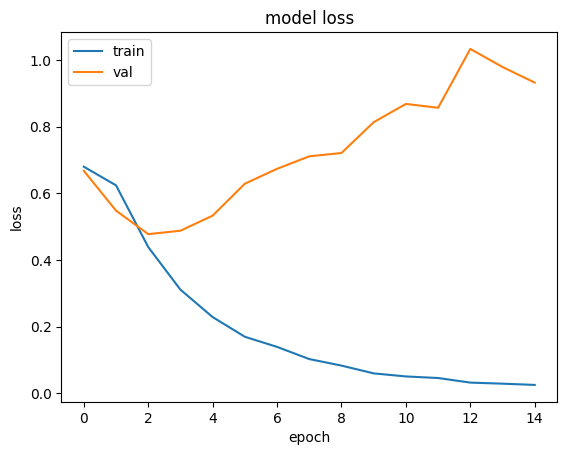

In [26]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

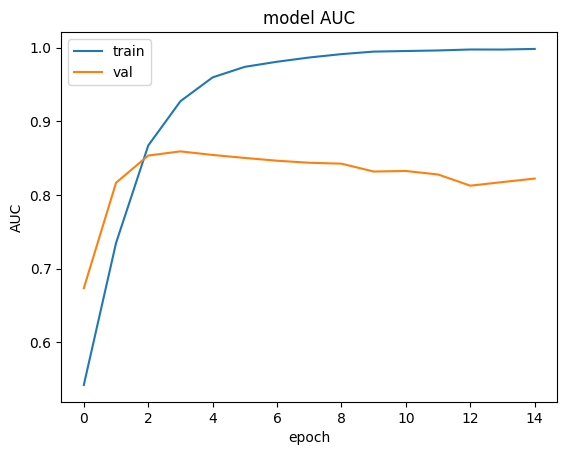

In [27]:
plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])
plt.title('model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [28]:
# check what teh submission file should look like
sample_sub = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
print(sample_sub.head())

   id  target
0   0       0
1   2       0
2   3       0
3   9       0
4  11       0


In [29]:
test_data["target"] = model.predict(test_data_padded)
# recode the data to binary format
test_data["target"] = np.where(test_data["target"] > 0.5, 1,0)
# drop the other columns
submission = test_data.drop(columns = ["keyword", "location", "text"])

102/102 ━━━━━━━━━━━━━━━━━━━━ 14s 121ms/step


In [30]:
print(submission.head())

   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1


In [31]:
submission.to_csv("submission.csv", index = False, header = True) 

glove_dir = '/kaggle/input/glove6b100dtxt'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

model = Sequential()
model.add(Embedding(len(word_index) + 1, 100, weights=[embedding_matrix],
                    trainable=False, input_length = max_length))
model.add(Bidirectional(LSTM(32, return_sequences=True, recurrent_dropout=0.3)))
model.add(GlobalMaxPool1D())
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(
  optimizer=opt,
  loss='binary_crossentropy',
  metrics=['AUC'], # AUC ?
)

tf.compat.v1.enable_eager_execution()

history = model.fit(
  train_padded,
  y_train,
  epochs=15,
  verbose = 1,
  shuffle = True,
    validation_data=(testing_padded, y_test))
